In [34]:
from getpass import getpass

admin_rdm_url = 'https://admin.staging.rdm.example.com/'
rdm_url = 'https://staging.rdm.example.com/'
idp_name_1 = 'GakuNin RDM IdP'
idp_username_1 = None
idp_password_1 = None
idp_name_2 = 'GakuNin RDM IdP'
idp_username_2 = None
idp_password_2 = None
default_result_path = None
close_on_fail = False
transition_timeout = 30000

target_organization = 'GakuNin RDM IdP'
entitlement_text = 'GakuNinRDMAdmin:loginNG_VR'

In [35]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

Username for GakuNin RDM IdP vr_test_admin_01
Password for vr_test_admin_01@GakuNin RDM IdP ········


(16, 20)

In [36]:
if idp_username_2 is None:
    idp_username_2 = input(prompt=f'Username for {idp_name_2}')
if idp_password_2 is None:
    idp_password_2 = getpass(prompt=f'Password for {idp_username_2}@{idp_name_2}')
(len(idp_username_2), len(idp_password_2))

Username for GakuNin RDM IdP vr_test_admin_02
Password for vr_test_admin_02@GakuNin RDM IdP ········


(16, 20)

# 定期監視-管理者-ログイン可否設定

- サブシステム名: 管理者
- ページ/アドオン: 管理者
- 機能分類: ログイン可否設定
- シナリオ名: ログイン可否設定
- 用意するテストデータ: URL一覧、アカウント(管理者ユーザー1: GRDM)

## GakuNin RDM管理者ページのURLを開く

①ブラウザを開き、画面右上の設定メニューから「シークレットモードで開く」を選択する。  
②新規画面が開かれ、画面上において、「シークレットモードです」と表示されていることを確認する。
以下、シークレットモードにて確認を行う。

③ブラウザを開き、下記URLにアクセスする。  
https://rdm.example.com/  

In [53]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/tmp/tmptr7cartb'

In [121]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path)

('20250504-082742', '/tmp/tmp8dkzueag')

Start epoch: 1746347263.1077516 seconds


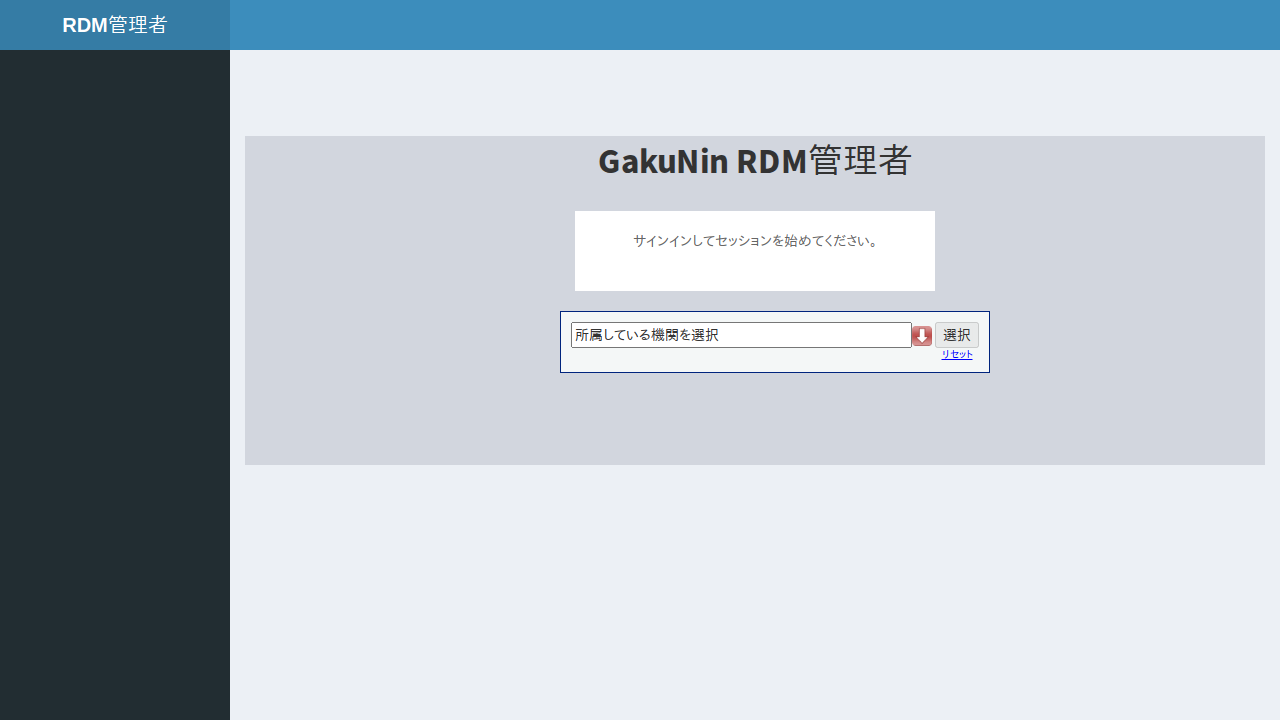

In [122]:
import time

async def _step(page):
    await page.goto(admin_rdm_url)

    await expect(page.locator('.login-logo')).to_be_visible(timeout=30000)

await run_pw(_step)

## ログイン情報を用いてGakuNin RDMにログインする

(IdPに関するログイン情報が与えられた場合、)
GakuNin Embeded DSのプルダウンを展開し、IdPリストから指定されたIdPを選択する。その後、アカウントのID/Passwordを入力して「Login」ボタンを押下する。

(IdPが指定されていない場合、)
CASのログイン操作を実施する。

Start epoch: 1746347263.8372138 seconds


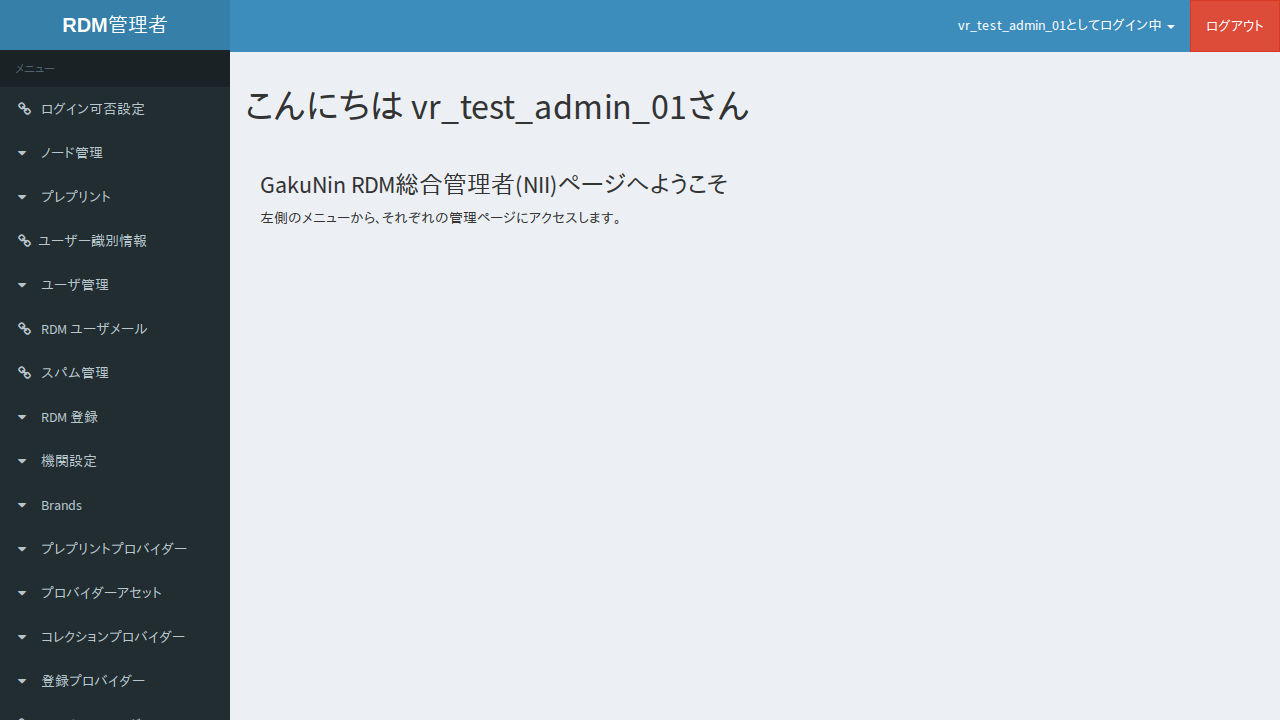

In [123]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login_as_admin(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    await expect(page.locator('//*[contains(@class, "btn-danger") and contains(text(), "ログアウト")]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 「ログイン可否設定」を押下し、eduPersonEntitlement ページを表示する

eduPersonEntitlementページが表示されること

Start epoch: 1746347265.759046 seconds


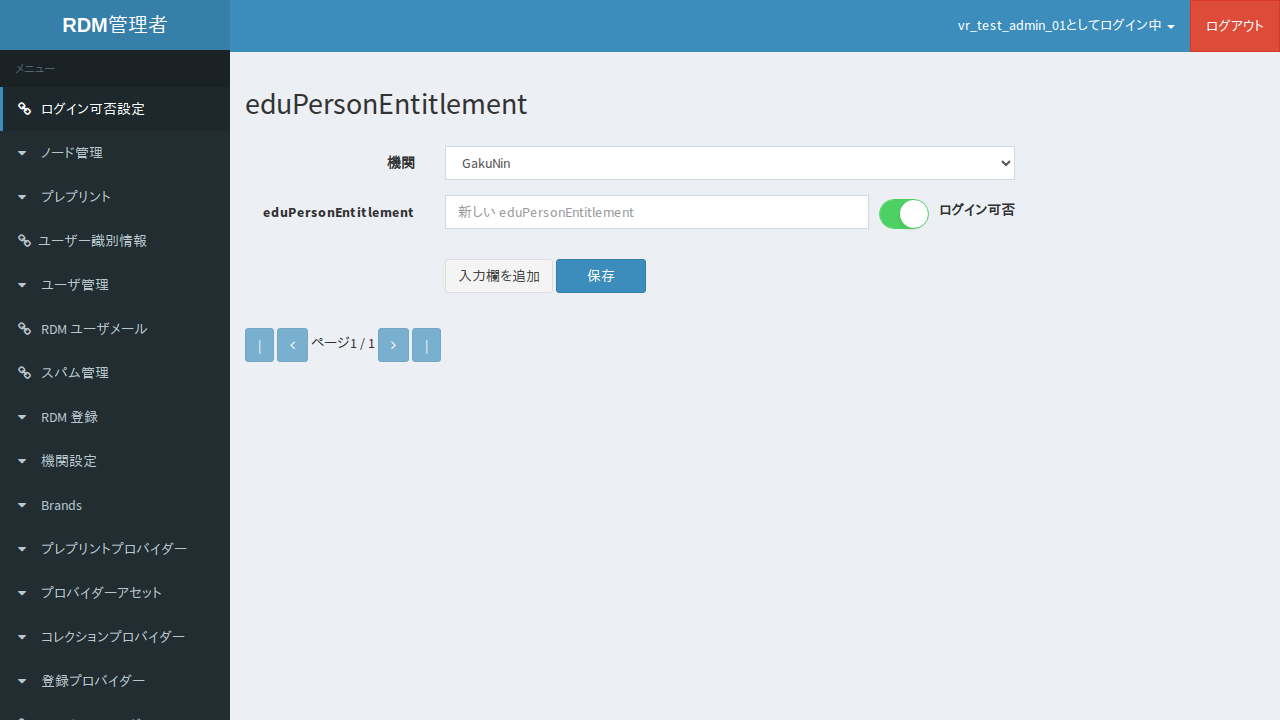

In [124]:
async def _step(page):
    await page.locator('//a[@href = "/institutions/entitlements/"]').click()

    await expect(page.locator('//h2[text() = "eduPersonEntitlement"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「機関」をプルダウンを展開する

Start epoch: 1746347266.108154 seconds


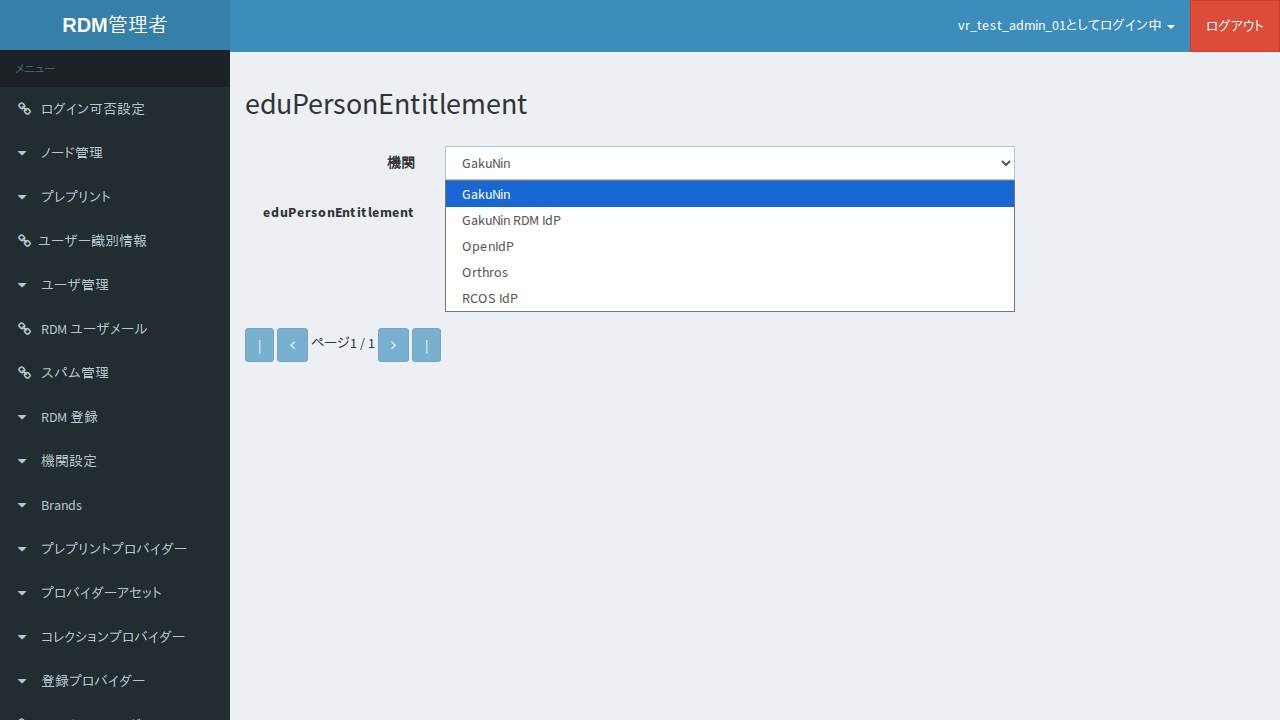

In [125]:
async def _step(page):
    await page.locator('#institution_id').click()

await run_pw(_step)

## IdPリストから「GakuNinRDM IdP」を選択する

Start epoch: 1746347266.3119318 seconds


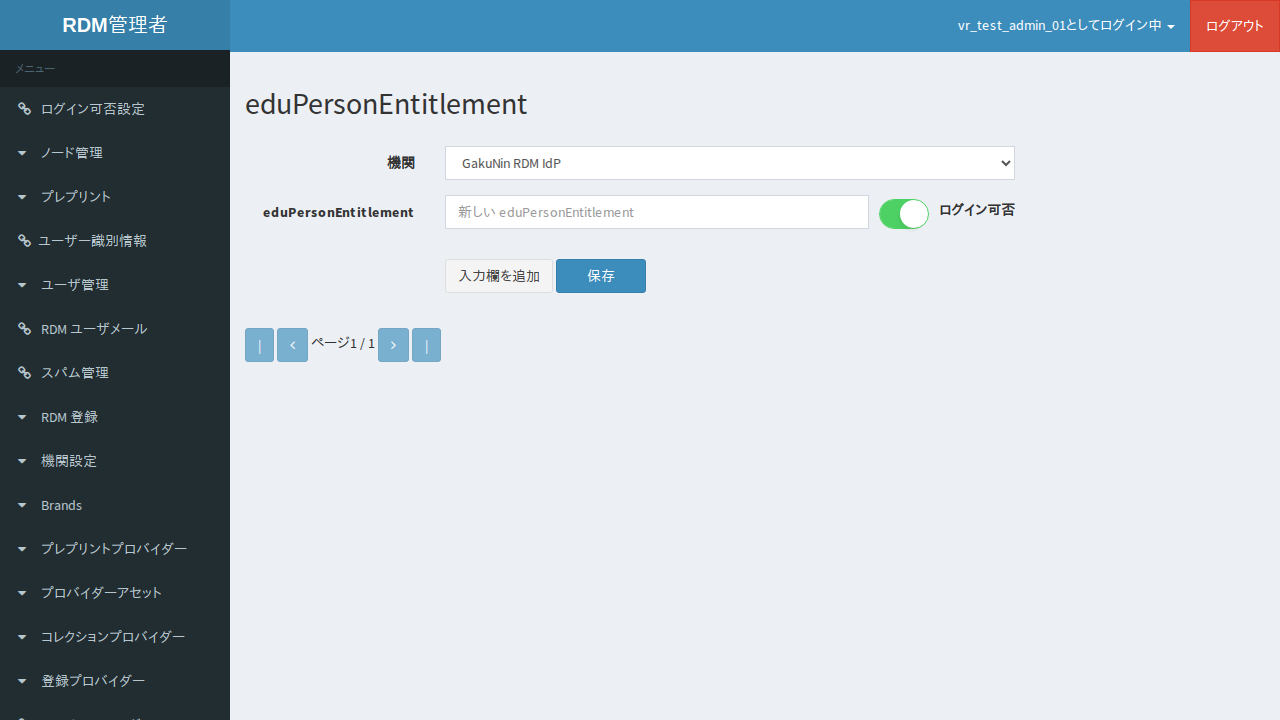

In [126]:
async def _step(page):
    await page.locator('#institution_id').select_option(target_organization)

await run_pw(_step)

## 「入力欄を追加」ボタンを押下する

Start epoch: 1746347266.5983186 seconds


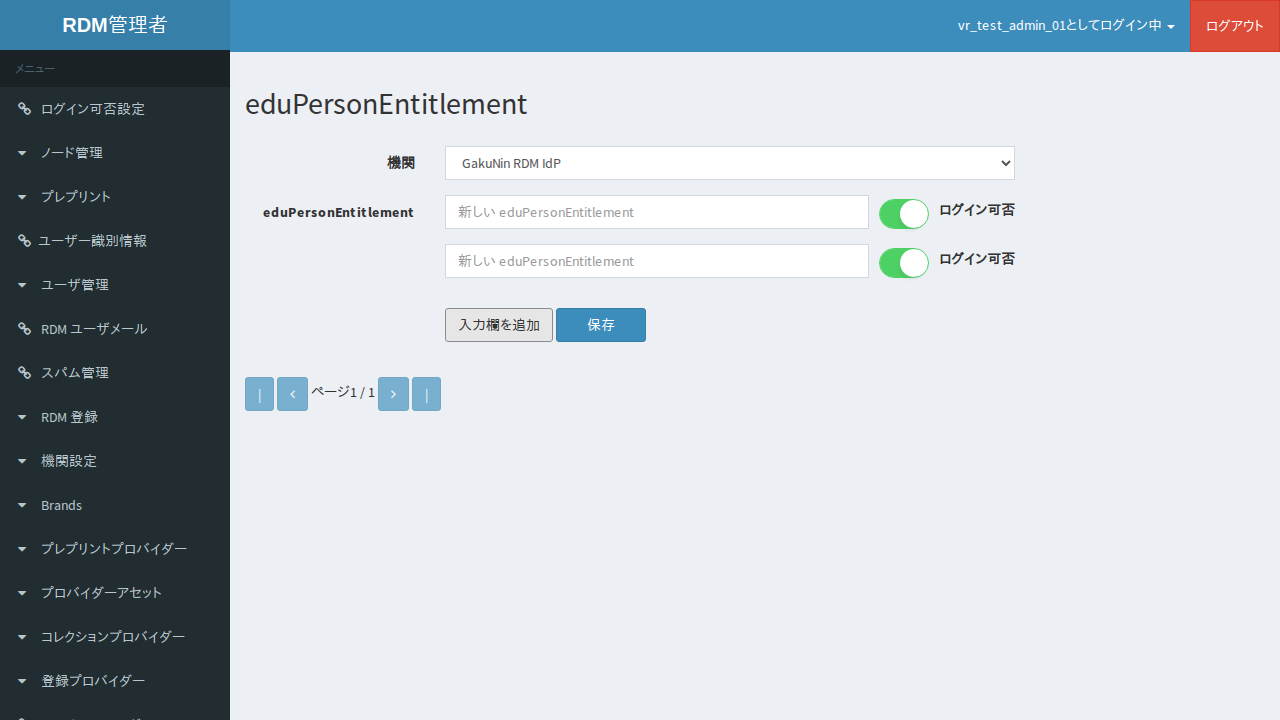

In [127]:
async def _step(page):
    await expect(page.locator('//*[@name = "entitlements"]')).to_have_count(1)
    await page.locator('//*[text() = "入力欄を追加"]').click()
    await expect(page.locator('//*[@name = "entitlements"]')).to_have_count(2)

await run_pw(_step)

## ブラウザをリロードし、「eduPersonEntitlement」で新しいeduPersonEntitlementを入力する

「GakuNinRDMAdmin:loginNG」

Start epoch: 1746347266.8121562 seconds


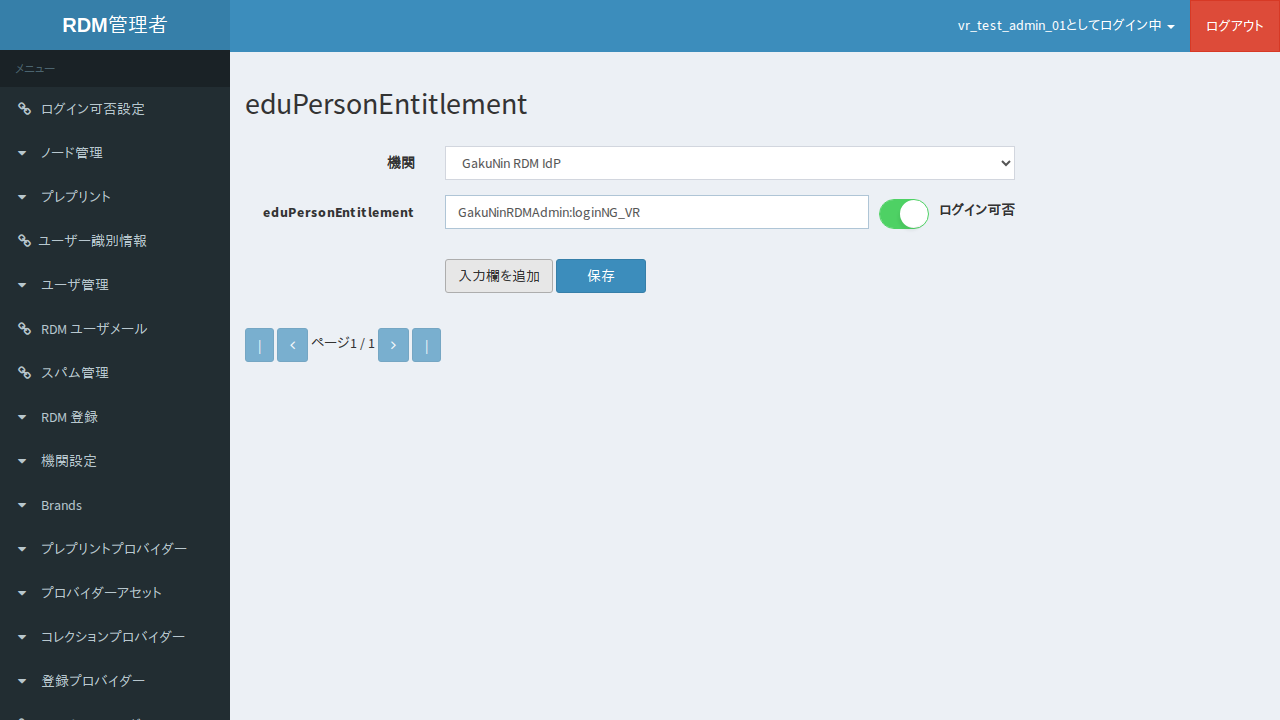

In [128]:
async def _step(page):
    await page.reload()
    await expect(page.locator('//*[@name = "entitlements"]')).to_have_count(1, timeout=transition_timeout)
    value = await page.locator('#institution_id').evaluate("el => el.options[el.selectedIndex].text")
    assert value == target_organization, (value, target_organization)

    await page.locator('//*[@name = "entitlements"]').fill(entitlement_text)

await run_pw(_step)

## テストユーザの「ログイン可否」を「否」にし、「保存」ボタンを押下する



Start epoch: 1746347267.2167888 seconds


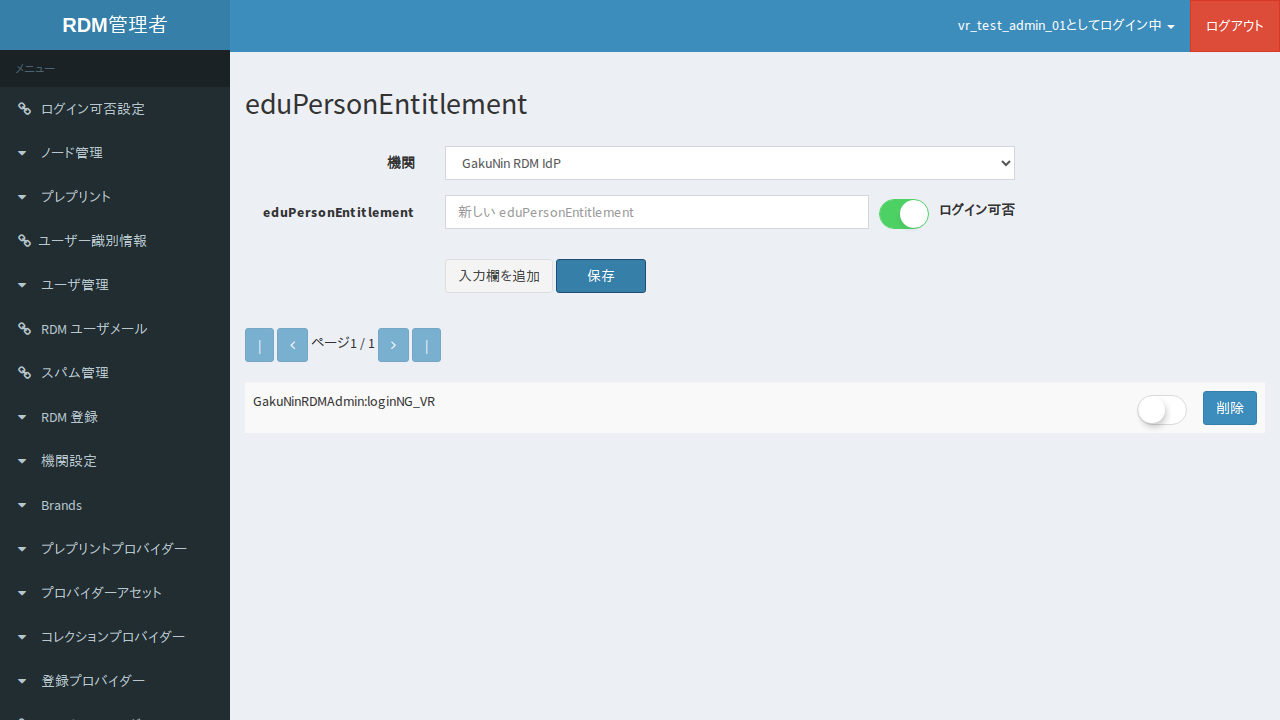

In [129]:
async def _step(page):
    await page.locator('//*[@name = "login_availability"]').click()
    await page.locator('//*[@type = "submit"]').click()

    await expect(page.locator(f'//*[contains(@class, "entitlement") and text() = "{entitlement_text}"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## GakuNin RDMのページに移動する

Start epoch: 1746347267.7136414 seconds


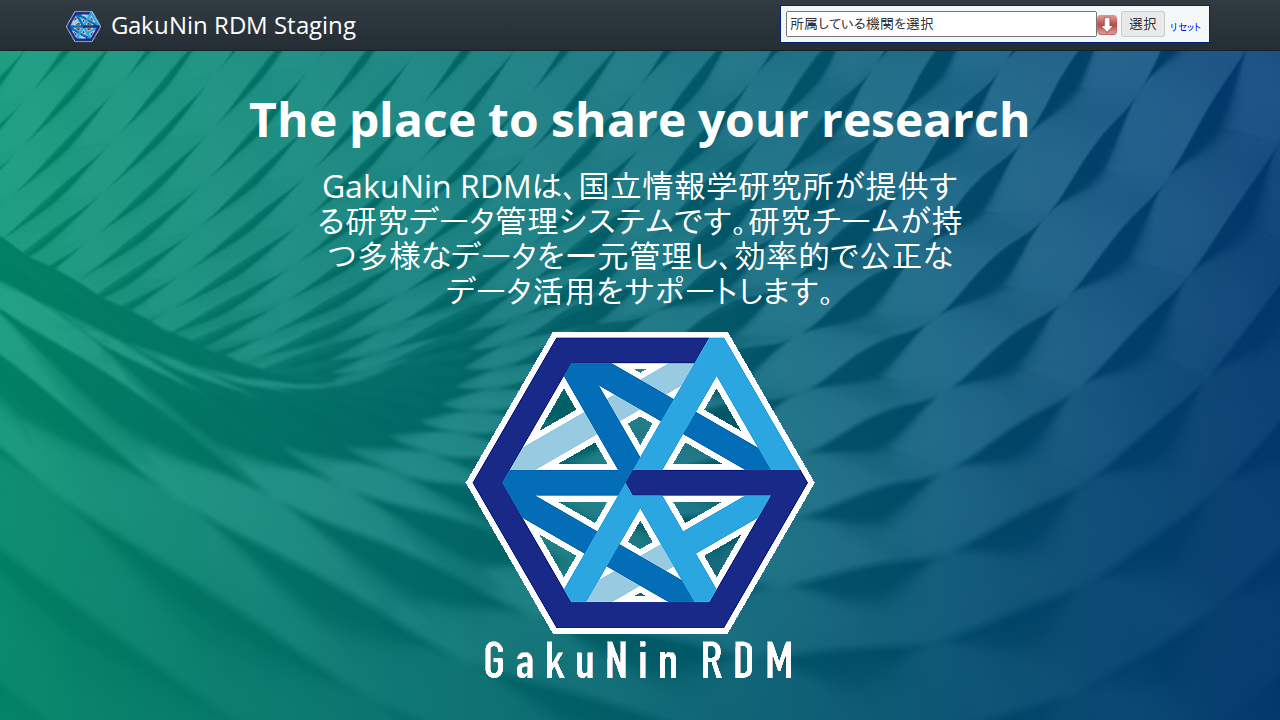

In [130]:
async def _step(page):
    await page.goto(rdm_url)

    # 同意する ボタンが現れるまで待つ
    await expect(page.locator('//button[text() = "同意する"]')).to_be_visible(timeout=transition_timeout)

    # 同意する をクリック
    await page.locator('//button[text() = "同意する"]').click()

    # 同意する が表示されなくなったことを確認
    await expect(page.locator('//button[text() = "同意する"]')).to_have_count(0, timeout=500)

await run_pw(_step, new_context=True)

## テストユーザ(ierae02)でログインする

Start epoch: 1746347269.8057995 seconds


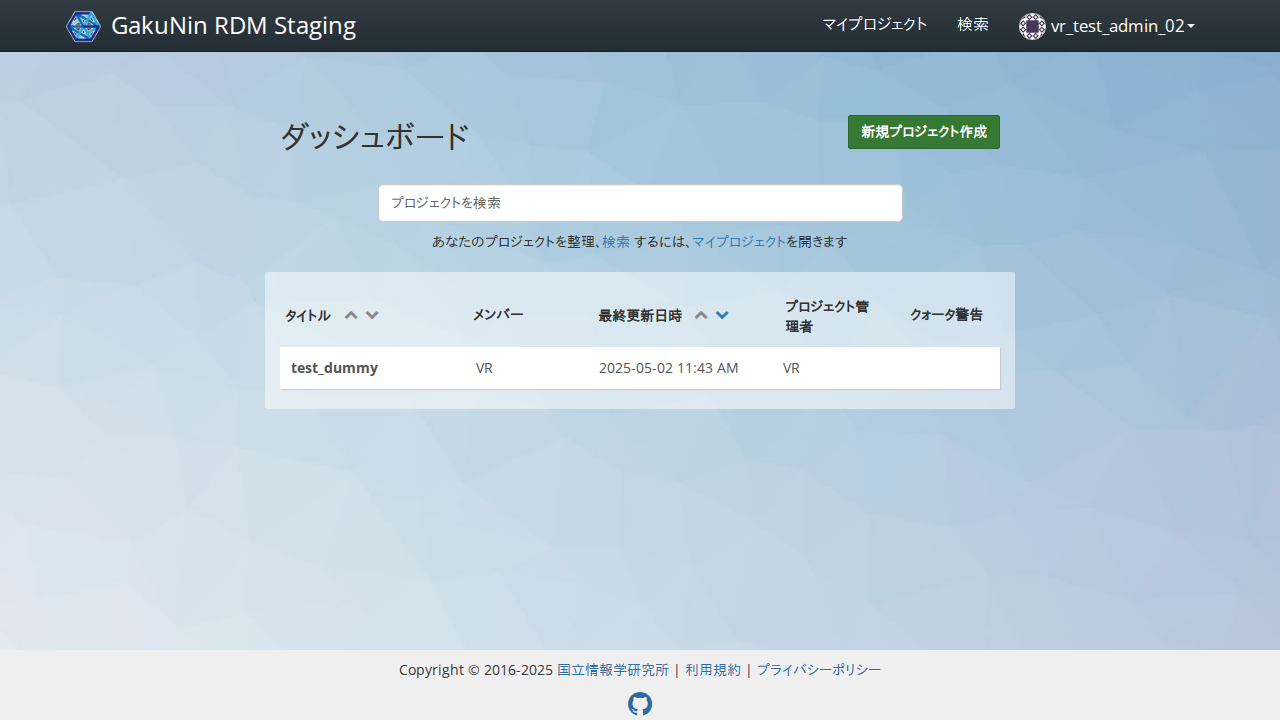

In [131]:
import scripts.grdm
importlib.reload(scripts.grdm)

# TODO ログインできないことを確認する

async def _step(page):
    await scripts.grdm.login(
        page, idp_name_2, idp_username_2, idp_password_2, transition_timeout=transition_timeout
    )

    await scripts.grdm.expect_dashboard(page, transition_timeout=transition_timeout)

await run_pw(_step)

## RDM管理者ページに戻り、テストユーザのログイン可否を「可」に戻し、「保存」ボタンを押下する

Start epoch: 1746347278.0866663 seconds


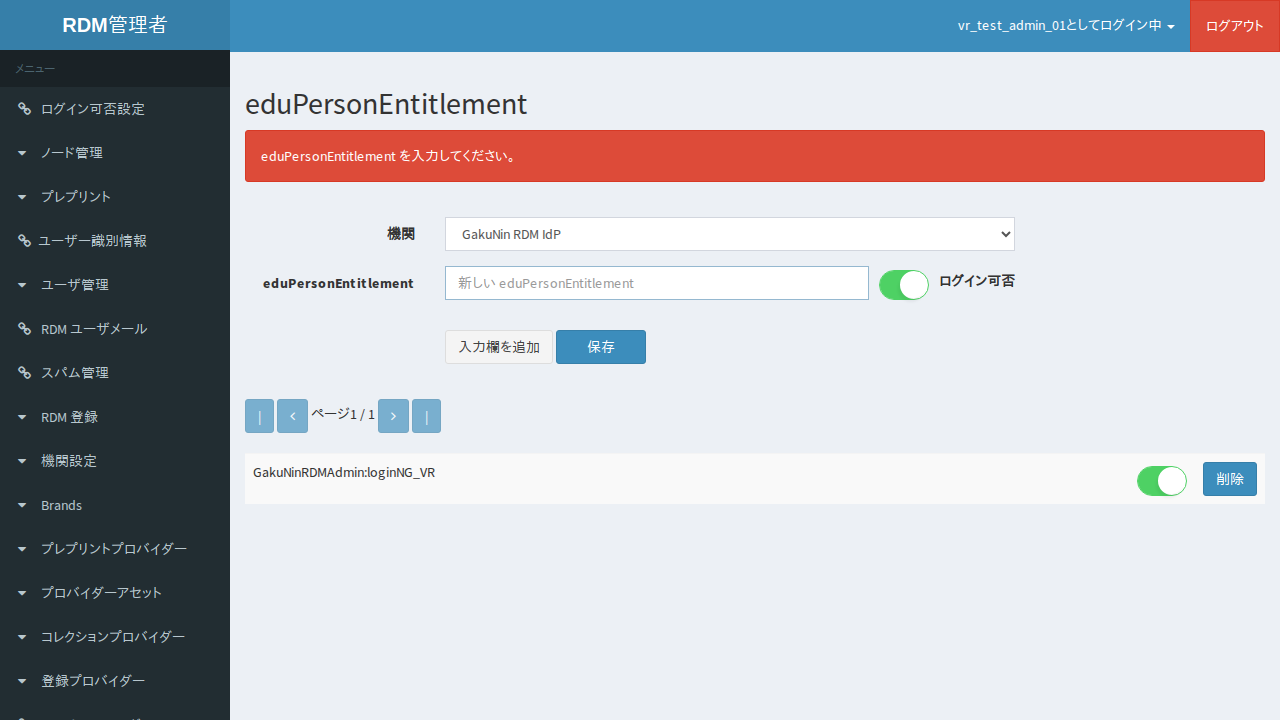

In [132]:
await close_latest_page()

async def _step(page):
    await page.locator(f'//*[contains(@class, "entitlement") and text() = "{entitlement_text}"]/following-sibling::*//input[@type = "checkbox"]').click()
    await page.locator('//*[@type = "submit"]').click()

    await expect(page.locator(f'//*[contains(@class, "entitlement") and text() = "{entitlement_text}"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## GakuNin RDMのページに移動する

Start epoch: 1746347278.6445987 seconds


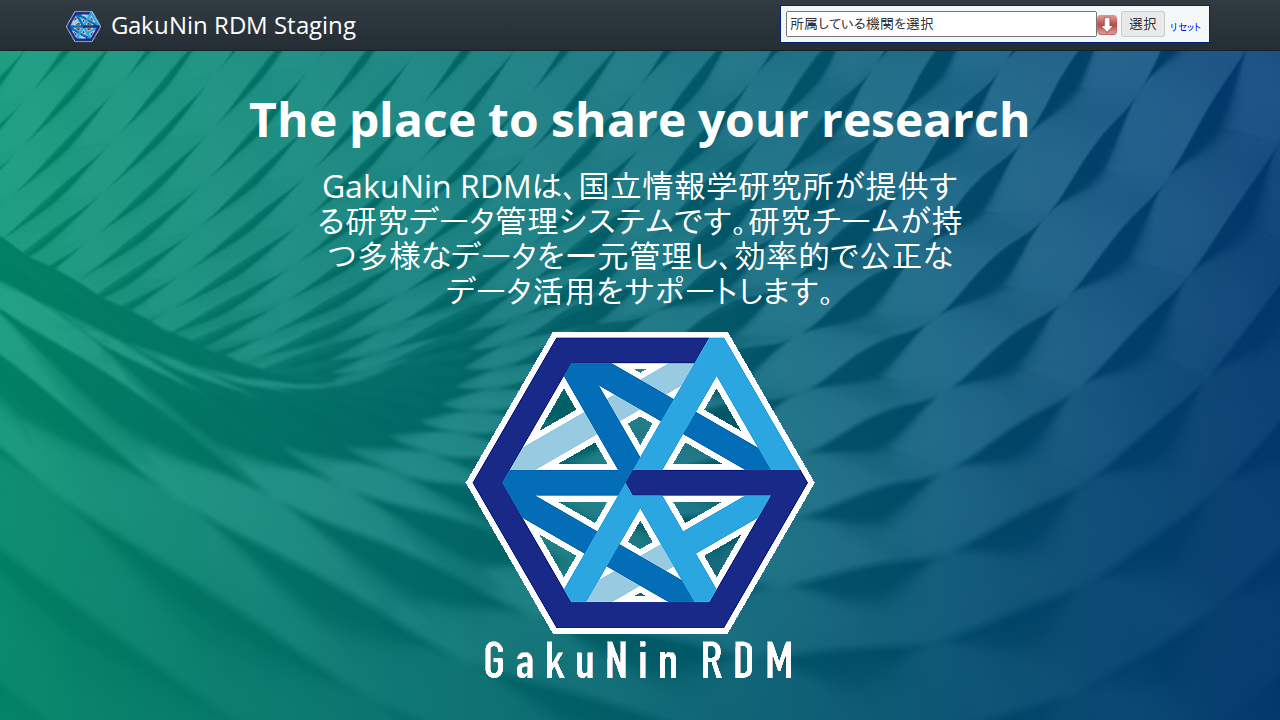

In [133]:
async def _step(page):
    await page.goto(rdm_url)

    # 同意する ボタンが現れるまで待つ
    await expect(page.locator('//button[text() = "同意する"]')).to_be_visible(timeout=transition_timeout)

    # 同意する をクリック
    await page.locator('//button[text() = "同意する"]').click()

    # 同意する が表示されなくなったことを確認
    await expect(page.locator('//button[text() = "同意する"]')).to_have_count(0, timeout=500)

await run_pw(_step, new_context=True)

## テストユーザ(ierae02)でログインする

Start epoch: 1746347280.883979 seconds


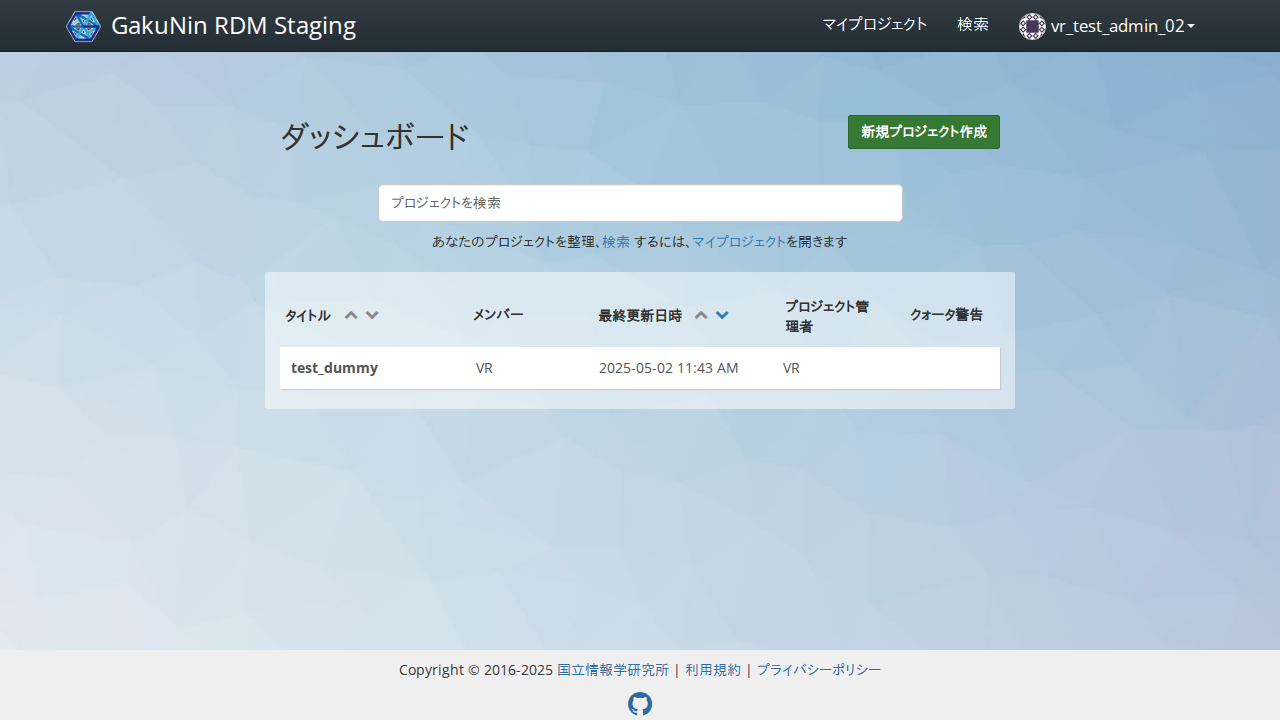

In [134]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login(
        page, idp_name_2, idp_username_2, idp_password_2, transition_timeout=transition_timeout
    )

    await scripts.grdm.expect_dashboard(page, transition_timeout=transition_timeout)

await run_pw(_step)

## 「削除」ボタンを押下する


Start epoch: 1746347289.1005163 seconds


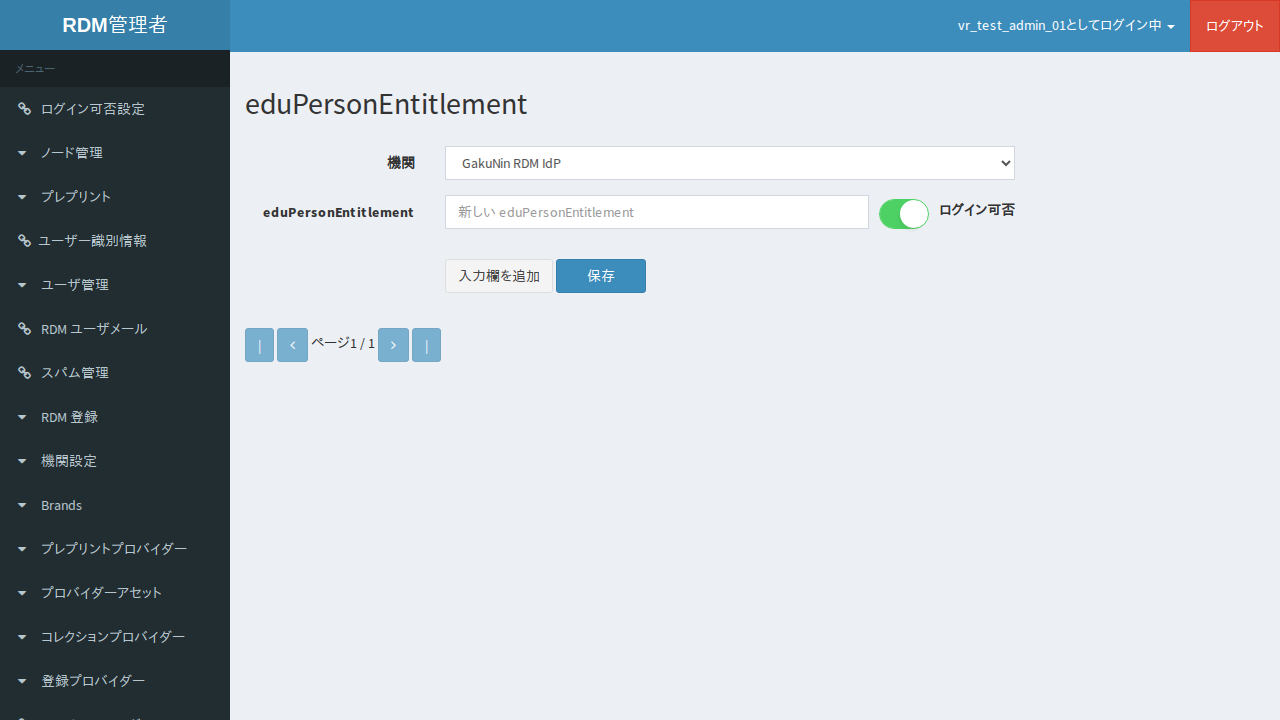

In [135]:
await close_latest_page()

async def _step(page):
    await page.locator('//a[contains(text(), "削除")]').click()

    await expect(page.locator(f'//*[contains(@class, "entitlement") and text() = "{entitlement_text}"]')).to_have_count(0, timeout=transition_timeout)

await run_pw(_step)

終了処理を実施。

In [136]:
await finish_pw_context()

Video: /tmp/tmp65hce91n/video-1.webm
HAR: /tmp/tmp65hce91n/har.zip


/home/jovyan/scripts/playwright.py:182: RuntimeWarning: coroutine '_finish_pw_context' was never awaited
  _finish_pw_context(screenshot=False, last_path=last_path)


In [137]:
!rm -fr {work_dir}